In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 10)
!date

%load_ext autoreload
%autoreload 2

Mon Jun 17 10:07:23 PDT 2019


# Compare 1940 MDS and CEF for some places

    WA state pop
    specific age, race, eth combos

    County
    
    
Potentially useful in undestanding data: https://usa.ipums.org/usa/resources/1940CensusDASTestData/EXT1940USCB.cbk

In [2]:
from dask.distributed import Client
client = Client(n_workers=1, threads_per_worker=3, processes=False, memory_limit='75GB')
client

Client Scheduler: inproc://10.158.100.160/164999/1,Cluster Workers: 1 Cores: 3 Memory: 75.00 GB


In [3]:
import dask.dataframe as dd

df = dd.read_csv('/snfs1/Project/Models/us_census/53_*.csv', include_path_column=True)

In [4]:
cef = pd.read_csv('/home/j/Project/Models/us_census/per_1940_raw.csv', index_col=0)
cef

/ihme/homes/abie/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,SERIAL,AGE,HISPAN,RACE,STATEFIP,COUNTY,ENUMDIST,GQ
0,36437747,34,0,1,53,30,40,1
1,36437747,15,0,1,53,30,40,1
2,36438380,42,0,1,53,30,70,1
3,36438380,37,0,1,53,30,70,1
4,36438380,16,0,1,53,30,70,1
...,...,...,...,...,...,...,...,...
2527,37045558,36,0,1,53,530,910,1
2528,37045692,43,0,1,53,530,920,1
2529,37045692,34,0,1,53,530,920,1
2530,37046102,24,0,1,53,530,930,1


# The total number of people in WA state is the same for each epsilon/replicate

In [5]:
df.groupby('path').race_eth.count().compute()

path
/snfs1/Project/Models/us_census/53_0.25-RUN1.csv    1741616
/snfs1/Project/Models/us_census/53_0.25-RUN2.csv    1741616
/snfs1/Project/Models/us_census/53_0.25-RUN3.csv    1741616
/snfs1/Project/Models/us_census/53_0.25-RUN4.csv    1741616
/snfs1/Project/Models/us_census/53_0.50-RUN1.csv    1741616
                                                     ...   
/snfs1/Project/Models/us_census/53_6.0-RUN4.csv     1741616
/snfs1/Project/Models/us_census/53_8.0-RUN1.csv     1741616
/snfs1/Project/Models/us_census/53_8.0-RUN2.csv     1741616
/snfs1/Project/Models/us_census/53_8.0-RUN3.csv     1741616
/snfs1/Project/Models/us_census/53_8.0-RUN4.csv     1741616
Name: race_eth, Length: 32, dtype: int64

In [6]:
# it also matches the number from the CEF (the thing without DP)
len(cef)

1741616

In [10]:
county_race_cnts = cef.groupby('COUNTY').RACE.value_counts()  # county population by race counts
county_cnts = county_race_cnts.unstack().fillna(0).sum(axis=1)
county_cnts

COUNTY
10      6227.0
30      8466.0
50     12101.0
70     34510.0
90     22017.0
        ...   
690     4295.0
710    30665.0
730    60444.0
750    27296.0
770    99424.0
Length: 39, dtype: float64

In [24]:
t = pd.DataFrame()
t['rate'] = county_cnts
t['id'] = list(map(lambda x: f'53{int(x//10):03d}', county_cnts.index))
t

,rate,id
COUNTY,,
10,6227.0,53001
30,8466.0,53003
50,12101.0,53005
70,34510.0,53007
90,22017.0,53009
...,...,...
690,4295.0,53069
710,30665.0,53071
730,60444.0,53073


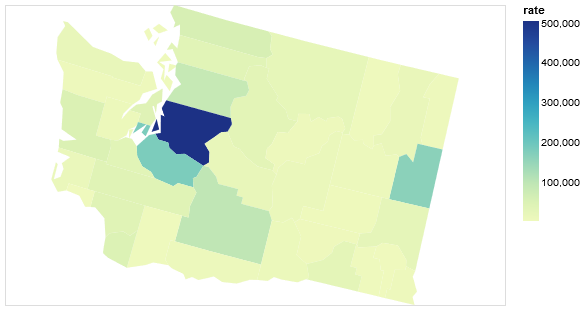

In [25]:
import altair as alt
alt.renderers.enable('notebook')

from vega_datasets import data

counties = alt.topo_feature(data.us_10m.url, 'counties')
source = data.unemployment.url

alt.Chart(counties).mark_geoshape().encode(
    color='rate:Q'
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(t, 'id', ['rate'])
).project(
    type='albersUsa'
).properties(
    width=500,
    height=300
)

In [18]:
t = pd.read_csv(source, sep='\t')
t[t.id.astype(str).str.startswith('53')]

,id,rate
2951,53001,0.065
2952,53003,0.081
2953,53005,0.058
2954,53007,0.065
2955,53009,0.085
...,...,...
2985,53069,0.114
2986,53071,0.055
2987,53073,0.078
2988,53075,0.047


The race-specific counts don't match exactly.  How close are they?

In [8]:
t = df.groupby('path').race_eth.apply(lambda s: s.value_counts(), meta=('x', 'f8')).compute()

In [9]:
t = t.unstack()
t

,1,2,3,4,5,6
path,,,,,,
/snfs1/Project/Models/us_census/53_0.25-RUN1.csv,1703830,7537,11048,2365,14479,2357
/snfs1/Project/Models/us_census/53_0.25-RUN2.csv,1703925,7396,11119,2402,14392,2382
/snfs1/Project/Models/us_census/53_0.25-RUN3.csv,1703848,7453,11044,2307,14565,2399
/snfs1/Project/Models/us_census/53_0.25-RUN4.csv,1703936,7210,11208,2475,14417,2370
/snfs1/Project/Models/us_census/53_0.50-RUN1.csv,1703867,7386,11155,2439,14466,2303
...,...,...,...,...,...,...
/snfs1/Project/Models/us_census/53_6.0-RUN4.csv,1703876,7446,11135,2364,14475,2320
/snfs1/Project/Models/us_census/53_8.0-RUN1.csv,1703874,7442,11131,2366,14482,2321
/snfs1/Project/Models/us_census/53_8.0-RUN2.csv,1703879,7445,11124,2367,14476,2325


In [11]:
cef.RACE.value_counts().sort_index()

1    1703876
2       7447
3      11130
4       2364
5      14479
6       2320
Name: RACE, dtype: int64

# this tally also confirms the interpretation of the race categories in the MDFs:
# they are coded to match the IPUMS CEF data

     RACE		Race [general version]
    1		White
    2		Black/African American/Negro
    3		American Indian or Alaska Native
    4		Chinese
    5		Japanese
    6		Other Asian or Pacific Islander

In [12]:
def extract_epsilon(df):
    s = df.reset_index().path.astype(str)
    def part_after_53(x):
        x1 = x.split('53_')[1]
        x2 = x1.split('-RUN')[0]
        return float(x2)
    return s.map(part_after_53).values
t['epsilon'] = extract_epsilon(t)
t

,1,2,3,4,5,6,epsilon
path,,,,,,,
/snfs1/Project/Models/us_census/53_0.25-RUN1.csv,1703830,7537,11048,2365,14479,2357,0.25
/snfs1/Project/Models/us_census/53_0.25-RUN2.csv,1703925,7396,11119,2402,14392,2382,0.25
/snfs1/Project/Models/us_census/53_0.25-RUN3.csv,1703848,7453,11044,2307,14565,2399,0.25
/snfs1/Project/Models/us_census/53_0.25-RUN4.csv,1703936,7210,11208,2475,14417,2370,0.25
/snfs1/Project/Models/us_census/53_0.50-RUN1.csv,1703867,7386,11155,2439,14466,2303,0.50
...,...,...,...,...,...,...,...
/snfs1/Project/Models/us_census/53_6.0-RUN4.csv,1703876,7446,11135,2364,14475,2320,6.00
/snfs1/Project/Models/us_census/53_8.0-RUN1.csv,1703874,7442,11131,2366,14482,2321,8.00
/snfs1/Project/Models/us_census/53_8.0-RUN2.csv,1703879,7445,11124,2367,14476,2325,8.00


In [13]:
def extract_replicate(df):
    s = df.reset_index().path.astype(str)
    def part_after_RUN(x):
        x1 = x.split('RUN')[1]
        x2 = x1.split('.csv')[0]
        return int(x2)
    return s.map(part_after_RUN).values
t['i'] = extract_replicate(t)
t

,1,2,3,4,5,6,epsilon,i
path,,,,,,,,
/snfs1/Project/Models/us_census/53_0.25-RUN1.csv,1703830,7537,11048,2365,14479,2357,0.25,1
/snfs1/Project/Models/us_census/53_0.25-RUN2.csv,1703925,7396,11119,2402,14392,2382,0.25,2
/snfs1/Project/Models/us_census/53_0.25-RUN3.csv,1703848,7453,11044,2307,14565,2399,0.25,3
/snfs1/Project/Models/us_census/53_0.25-RUN4.csv,1703936,7210,11208,2475,14417,2370,0.25,4
/snfs1/Project/Models/us_census/53_0.50-RUN1.csv,1703867,7386,11155,2439,14466,2303,0.50,1
...,...,...,...,...,...,...,...,...
/snfs1/Project/Models/us_census/53_6.0-RUN4.csv,1703876,7446,11135,2364,14475,2320,6.00,4
/snfs1/Project/Models/us_census/53_8.0-RUN1.csv,1703874,7442,11131,2366,14482,2321,8.00,1
/snfs1/Project/Models/us_census/53_8.0-RUN2.csv,1703879,7445,11124,2367,14476,2325,8.00,2


In [14]:
plt.xkcd()

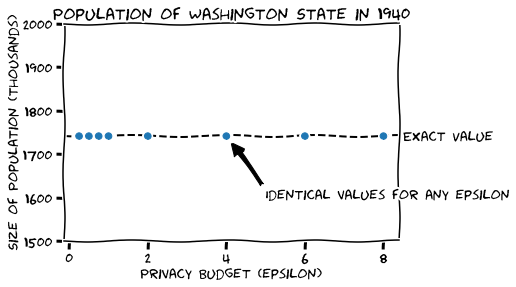

In [17]:
plt.axhline(len(cef)/1_000, color='k', linestyle='--')
plt.text(8.5, len(cef)/1_000, 'Exact Value', va='center', ha='left')
plt.plot(t.epsilon, (t[1]+t[2]+t[3]+t[4]+t[5]+t[6])/1_000, 'o')
plt.xlabel('Privacy Budget (epsilon)')
plt.ylabel('Size of Population (thousands)')
plt.title('Population of Washington State in 1940')
plt.annotate('Identical values for any epsilon', xy=(4.1, 1730), xytext=(5, 1600),
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.axis(ymin=1_500, ymax=2_000);

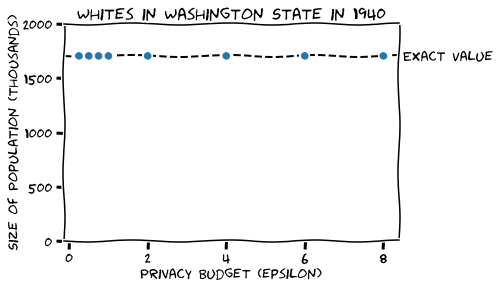

In [18]:
plt.axhline(len(cef[cef.RACE==1])/1_000, color='k', linestyle='--')
plt.text(8.5, len(cef[cef.RACE==1])/1_000, 'Exact Value', va='center', ha='left')

plt.plot(t.epsilon, t[1]/1_000, 'o')
plt.xlabel('Privacy Budget (epsilon)')
plt.ylabel('Size of Population (thousands)')
plt.title('Whites in Washington State in 1940')
plt.axis(ymin=0, ymax=2_000);

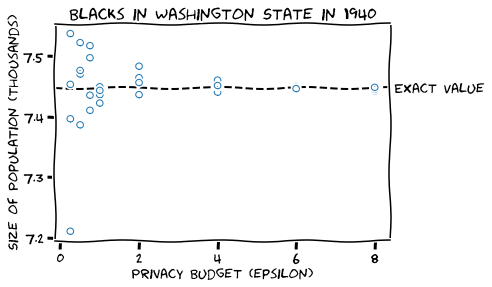

In [19]:
plt.axhline(len(cef[cef.RACE==2])/1_000, color='k', linestyle='--')
plt.text(8.5, len(cef[cef.RACE==2])/1_000, 'Exact Value', va='center', ha='left')

plt.plot(t.epsilon, t[2]/1_000, 'o', mec='C0', mew=1, color='none')
plt.xlabel('Privacy Budget (epsilon)')
plt.ylabel('Size of Population (thousands)')
plt.title('Blacks in Washington State in 1940');

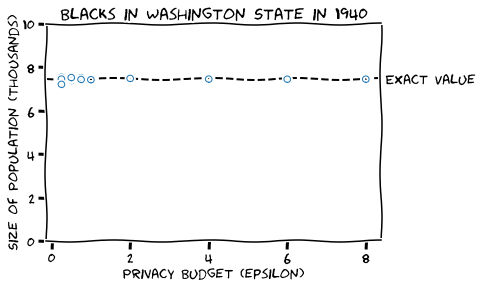

In [20]:
plt.axhline(len(cef[cef.RACE==2])/1_000, color='k', linestyle='--')
plt.text(8.5, len(cef[cef.RACE==2])/1_000, 'Exact Value', va='center', ha='left')

plt.plot(t.epsilon, t[2]/1_000, 'o', mec='C0', mew=1, color='none')
plt.xlabel('Privacy Budget (epsilon)')
plt.ylabel('Size of Population (thousands)')
plt.axis(ymin=0, ymax=10)
plt.title('Blacks in Washington State in 1940');

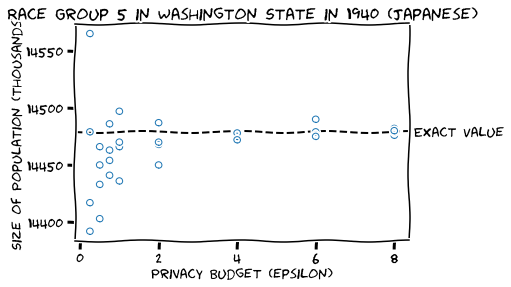

In [21]:
plt.axhline(len(cef[cef.RACE==5]), color='k', linestyle='--')
plt.text(8.5, len(cef[cef.RACE==5]), 'Exact Value', va='center', ha='left')

plt.plot(t.epsilon, t[5], 'o', mec='C0', mew=1, color='none')
plt.xlabel('Privacy Budget (epsilon)')
plt.ylabel('Size of Population (thousands)')
# plt.axis(ymin=0, ymax=10)
plt.title('Race Group 5 in Washington State in 1940 (Japanese)');

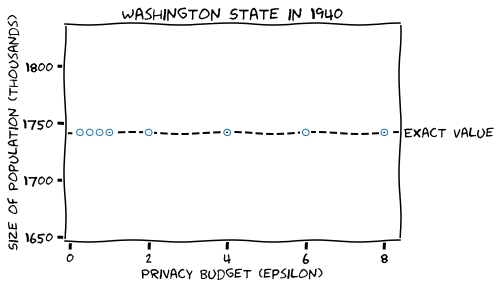

In [22]:
plt.axhline(len(cef)/1_000, color='k', linestyle='--')
plt.text(8.5, len(cef)/1_000, 'Exact Value', va='center', ha='left')

plt.plot(t.epsilon, (t[1]+t[2]+t[3]+t[4]+t[5]+t[6])/1_000, 'o', mec='C0', mew=1, color='none')
plt.xlabel('Privacy Budget (epsilon)')
plt.ylabel('Size of Population (thousands)')
plt.title('Washington State in 1940');

# Same experiment, but by county

But are there actually counties in this data?

In [23]:
t = df.groupby(['path', 'county']).race_eth.apply(lambda s: s.value_counts(), meta=('x', 'f8')).compute()

In [24]:
t = t.unstack()

In [25]:
t['i'] = extract_replicate(t)
t['epsilon'] = extract_epsilon(t)

In [26]:
t = t.fillna(0)

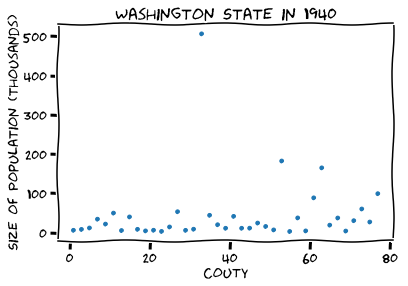

In [30]:
plt.plot(t.reset_index().county, (t[1]+t[2]+t[3]+t[4]+t[5]+t[6])/1_000, '.')
plt.xlabel('Couty')
plt.ylabel('Size of Population (thousands)')
plt.title('Washington State in 1940');

In [31]:
(t[1]+t[2]+t[3]+t[4]+t[5]+t[6]).sort_values()

path                                              county
/snfs1/Project/Models/us_census/53_0.75-RUN4.csv  55          3145.0
/snfs1/Project/Models/us_census/53_1.0-RUN1.csv   55          3159.0
/snfs1/Project/Models/us_census/53_0.50-RUN3.csv  55          3162.0
/snfs1/Project/Models/us_census/53_2.0-RUN3.csv   55          3168.0
/snfs1/Project/Models/us_census/53_6.0-RUN1.csv   55          3177.0
                                                              ...   
/snfs1/Project/Models/us_census/53_4.0-RUN4.csv   33        506324.0
/snfs1/Project/Models/us_census/53_8.0-RUN3.csv   33        506333.0
/snfs1/Project/Models/us_census/53_8.0-RUN1.csv   33        506339.0
/snfs1/Project/Models/us_census/53_8.0-RUN2.csv   33        506339.0
/snfs1/Project/Models/us_census/53_6.0-RUN4.csv   33        506343.0
Length: 1248, dtype: float64

In [39]:
cef.COUNTY.value_counts()

330    506344
530    182599
630    165172
770     99424
610     88857
        ...  
190      4723
590      4645
690      4295
230      3361
550      3180
Name: COUNTY, Length: 39, dtype: int64

In [32]:
tt = t.copy()

In [59]:
# Couty 33 is King County, which is where Seattle is https://en.wikipedia.org/wiki/List_of_counties_in_Washington
t = tt.query('county == 33')
t

,,1,2,3,4,5,6,i,epsilon
path,county,,,,,,,,
/snfs1/Project/Models/us_census/53_0.25-RUN1.csv,33,488452.0,3937.0,616.0,1770.0,9765.0,1333.0,1,0.25
/snfs1/Project/Models/us_census/53_0.25-RUN2.csv,33,488346.0,3944.0,617.0,1753.0,9719.0,1317.0,2,0.25
/snfs1/Project/Models/us_census/53_0.25-RUN3.csv,33,488378.0,3965.0,634.0,1699.0,9777.0,1681.0,3,0.25
/snfs1/Project/Models/us_census/53_0.25-RUN4.csv,33,488469.0,3915.0,738.0,1814.0,9891.0,1424.0,4,0.25
/snfs1/Project/Models/us_census/53_0.50-RUN1.csv,33,488510.0,3929.0,680.0,1723.0,9839.0,1499.0,1,0.50
...,...,...,...,...,...,...,...,...,...
/snfs1/Project/Models/us_census/53_6.0-RUN4.csv,33,488418.0,4047.0,596.0,1838.0,9845.0,1599.0,4,6.00
/snfs1/Project/Models/us_census/53_8.0-RUN1.csv,33,488433.0,4047.0,585.0,1836.0,9843.0,1595.0,1,8.00
/snfs1/Project/Models/us_census/53_8.0-RUN2.csv,33,488417.0,4053.0,592.0,1838.0,9837.0,1602.0,2,8.00


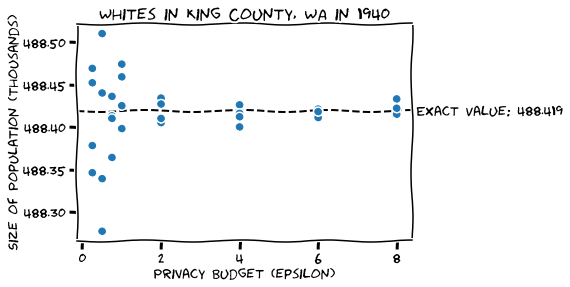

In [62]:
exact_val = len(cef[(cef.RACE==1)&(cef.COUNTY==330)])/1_000
plt.axhline(exact_val, color='k', linestyle='--')
plt.text(8.5, exact_val, f'Exact Value: {exact_val:.3f}', va='center', ha='left')

plt.plot(t.epsilon, t[1]/1_000, 'o')
plt.xlabel('Privacy Budget (epsilon)')
plt.ylabel('Size of Population (thousands)')
plt.title('Whites in King County, WA in 1940');
# plt.axis(ymin=0);

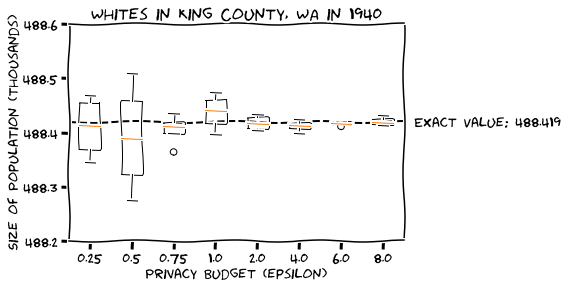

In [65]:
exact_val = len(cef[(cef.RACE==1)&(cef.COUNTY==330)])/1_000
plt.axhline(exact_val, color='k', linestyle='--')
plt.text(8.75, exact_val, f'Exact Value: {exact_val:.3f}', va='center', ha='left')

plt.boxplot((t.set_index(['epsilon', 'i'])[1]/1_000).unstack())
plt.xticks(1+np.arange(len(t.epsilon.unique())), t.epsilon.unique())
plt.xlabel('Privacy Budget (epsilon)')
plt.ylabel('Size of Population (thousands)')
plt.title('Whites in King County, WA in 1940')
plt.axis(ymin=488.2,ymax=488.6);

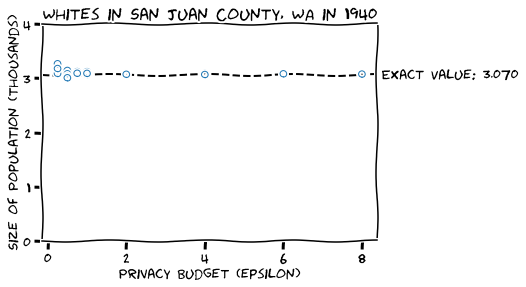

In [66]:
exact_val = len(cef[(cef.RACE==1)&(cef.COUNTY==550)])/1_000
plt.axhline(exact_val, color='k', linestyle='--')
plt.text(8.5, exact_val, f'Exact Value: {exact_val:.3f}', va='center', ha='left')

t = tt.query('county == 55') # San Juan County

plt.plot(t.epsilon, t[1]/1_000, 'o', mec='C0', mew=1, color='none')
plt.xlabel('Privacy Budget (epsilon)')
plt.ylabel('Size of Population (thousands)')
plt.title('Whites in San Juan County, WA in 1940');
plt.axis(ymin=0, ymax=4)
plt.grid();

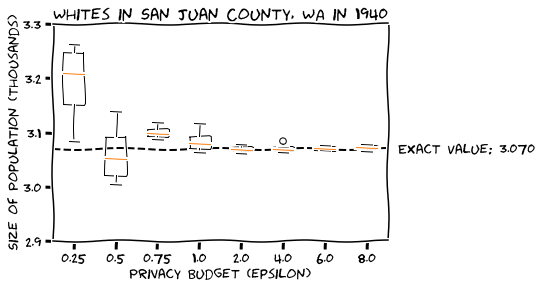

In [67]:
exact_val = len(cef[(cef.RACE==1)&(cef.COUNTY==550)])/1_000
plt.axhline(exact_val, color='k', linestyle='--')
plt.text(8.75, exact_val, f'Exact Value: {exact_val:.3f}', va='center', ha='left')

plt.boxplot((t.set_index(['epsilon', 'i'])[1]/1_000).unstack(), notch=False, )
plt.xticks(1+np.arange(len(t.epsilon.unique())), t.epsilon.unique())
plt.xlabel('Privacy Budget (epsilon)')
plt.ylabel('Size of Population (thousands)')
plt.title('Whites in San Juan County, WA in 1940')
plt.axis(ymin=2.9,ymax=3.3);

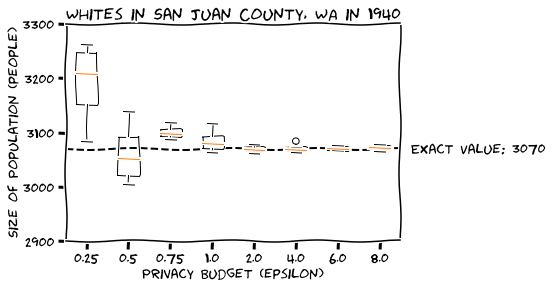

In [68]:
exact_val = len(cef[(cef.RACE==1)&(cef.COUNTY==550)])
plt.axhline(exact_val, color='k', linestyle='--')
plt.text(8.75, exact_val, f'Exact Value: {exact_val:d}', va='center', ha='left')

plt.boxplot((t.set_index(['epsilon', 'i'])[1]).unstack(), notch=False, )
plt.xticks(1+np.arange(len(t.epsilon.unique())), t.epsilon.unique())
plt.xlabel('Privacy Budget (epsilon)')
plt.ylabel('Size of Population (people)')
plt.title('Whites in San Juan County, WA in 1940')
plt.axis(ymin=2_900,ymax=3_300);

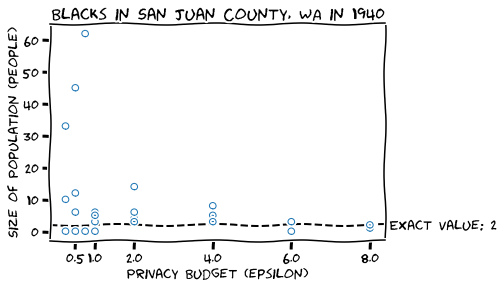

In [69]:
exact_val = len(cef[(cef.RACE==2)&(cef.COUNTY==550)])
plt.axhline(exact_val, color='k', linestyle='--')
plt.text(8.5, exact_val, f'Exact Value: {exact_val:d}', va='center', ha='left')

t = tt.query('county == 55')

plt.plot(t.epsilon, t[2], 'o', mec='C0', mew=1, color='none')
plt.xlabel('Privacy Budget (epsilon)')
plt.ylabel('Size of Population (people)')
plt.title('Blacks in San Juan County, WA in 1940');
# plt.axis(ymin=0, ymax=50)
plt.grid()
plt.xticks([.5, 1., 2, 4, 6, 8]);

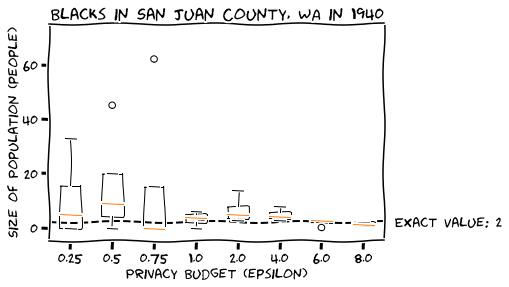

In [70]:
exact_val = len(cef[(cef.RACE==2)&(cef.COUNTY==550)])
plt.axhline(exact_val, color='k', linestyle='--')
plt.text(8.75, exact_val, f'Exact Value: {exact_val:d}', va='center', ha='left')

plt.boxplot((t.set_index(['epsilon', 'i'])[2]).unstack(), notch=False, meanline=False, showmeans=False, )
plt.xticks(1+np.arange(len(t.epsilon.unique())), t.epsilon.unique())
plt.xlabel('Privacy Budget (epsilon)')
plt.ylabel('Size of Population (people)')
plt.title('Blacks in San Juan County, WA in 1940')
plt.axis(ymin=-5,ymax=75);
#plt.semilogy()
#plt.yticks([1,5,25,75], [1,5,25,75]);

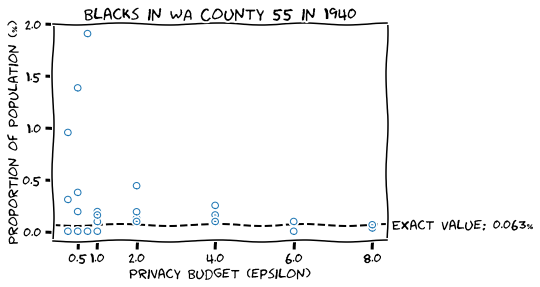

In [71]:
exact_val = np.mean(cef[(cef.COUNTY==550)].RACE==2)*100
plt.axhline(exact_val, color='k', linestyle='--')
plt.text(8.5, exact_val, f'Exact Value: {exact_val:.3f}%', va='center', ha='left')

t = tt.query('county == 55')
t_total = (t[1]+t[2]+t[3]+t[4]+t[5]+t[6])

plt.plot(t.epsilon, 100*t[2]/t_total, 'o', mec='C0', mew=1, color='none')
plt.xlabel('Privacy Budget (epsilon)')
plt.ylabel('Proportion of Population (%)')
plt.title('Blacks in San Juan County, WA in 1940')
# plt.axis(ymin=0, ymax=50)
plt.grid()
plt.xticks([.5, 1., 2, 4, 6, 8]);


# How do the counts compare at the county level?

In [84]:
t = df.groupby(['path', 'county']).race_eth.count().compute()
t.name = 'dp_count'

In [85]:
t = t.reset_index()

In [86]:
t['i'] = extract_replicate(t)
t['epsilon'] = extract_epsilon(t)

In [87]:
cef['county'] = cef.COUNTY//10
exact_val = cef.groupby('county').RACE.count()
exact_val.name = 'exact_count'

pd.merge(t, exact_val.reset_index(), on='county')

,path,county,dp_count,i,epsilon,exact_count
0,/snfs1/Project/Models/us_census/53_0.25-RUN1.csv,1,6203,1,0.25,6227
1,/snfs1/Project/Models/us_census/53_0.25-RUN2.csv,1,6446,2,0.25,6227
2,/snfs1/Project/Models/us_census/53_0.25-RUN3.csv,1,6299,3,0.25,6227
3,/snfs1/Project/Models/us_census/53_0.25-RUN4.csv,1,6183,4,0.25,6227
4,/snfs1/Project/Models/us_census/53_0.50-RUN1.csv,1,6333,1,0.50,6227
...,...,...,...,...,...,...
1243,/snfs1/Project/Models/us_census/53_6.0-RUN4.csv,77,99409,4,6.00,99424
1244,/snfs1/Project/Models/us_census/53_8.0-RUN1.csv,77,99431,1,8.00,99424
1245,/snfs1/Project/Models/us_census/53_8.0-RUN2.csv,77,99419,2,8.00,99424
1246,/snfs1/Project/Models/us_census/53_8.0-RUN3.csv,77,99410,3,8.00,99424


In [88]:
import seaborn as sns

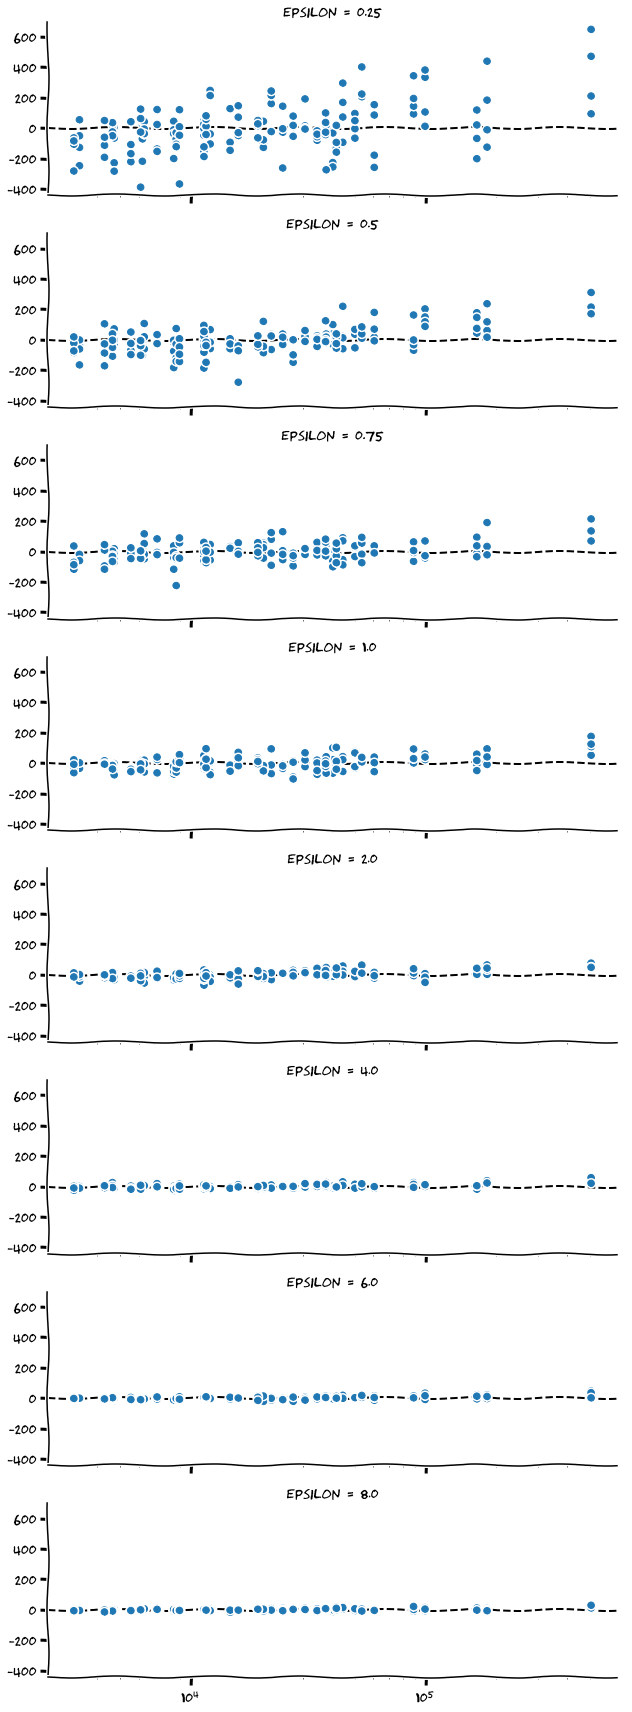

In [101]:
tt = pd.merge(t, exact_val.reset_index(), on='county')
tt['dp - exact'] = tt.exact_count - tt.dp_count

g = sns.FacetGrid(tt, row='epsilon', aspect=3)
g.map(plt.axhline, y=0, linestyle='--', color='k')
g.map(plt.semilogx, 'exact_count', 'dp - exact', marker='o', linestyle='none')
g.map(plt.grid, b=True);
# xlabel exact county size
# ylabel residual = dp_county size - exact_county_size
# plt.subplots_adjust(hspace=.5)

# Next do it again for ENUMDIST